In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from sklearn.metrics import mean_squared_error
from datetime import datetime
plt.style.use('fivethirtyeight')

In [2]:
# Fetch Bitcoin historical data from Yahoo Finance
ticker = "BTC-USD"
end=datetime.now() # current date
start = datetime(end.year-15,end.month,end.day) # 15 years before the current date
data = yf.download(ticker, start=start, end=end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
data

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...
2025-03-14,83969.101562,85263.289062,80797.562500,81066.992188,29588112414
2025-03-15,84343.109375,84672.671875,83639.593750,83968.406250,13650491277


In [4]:
data = data[['Close']]
data = data.dropna()

In [5]:
data

Price,Close
Ticker,BTC-USD
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2025-03-14,83969.101562
2025-03-15,84343.109375


In [6]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [7]:
# Split the data into training and testing sets
time_step = 60
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

In [8]:
# Reshape data for LSTM/GRU
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
# Function to build models
def build_model(model_type='LSTM'):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(50, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
        model.add(Dropout(0.2))
        model.add(GRU(50, return_sequences=False))

    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [10]:
# Train and evaluate LSTM model
lstm_model = build_model('LSTM')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0070 - val_loss: 0.0013
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6.4302e-04 - val_loss: 0.0011
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.2115e-04 - val_loss: 0.0011
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4799e-04 - val_loss: 0.0037
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9071e-04 - val_loss: 8.5961e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0332e-04 - val_loss: 6.8664e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7882e-04 - val_loss: 7.7516e-04
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1078e-04 - val_loss: 0.0022
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.0149e-04 - val_loss: 6.4829e-04
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.7395e-04 - val_loss: 0.0017
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.1632e-04 - val_loss: 0.0039
Epoch 1

In [11]:
# Train and evaluate GRU model
gru_model = build_model('GRU')
gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0114 - val_loss: 5.2234e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6.2244e-04 - val_loss: 0.0022
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6401e-04 - val_loss: 0.0015
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6634e-04 - val_loss: 6.0341e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.2896e-04 - val_loss: 4.3310e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8668e-04 - val_loss: 5.8628e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3348e-04 - val_loss: 4.0546e-04
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9336e-04 - val_loss: 6.3752e-04
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6447e-04 - val_loss: 4.0895e-04
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8984e-04 - val_loss: 3.5778e-04
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.4756e-04 - val_loss

In [12]:
# Function to predict future prices
def predict_future(model, last_data, future_days=30):
    future_predictions = []
    input_seq = last_data[-time_step:].reshape(1, time_step, 1)

    for _ in range(future_days):
        pred = model.predict(input_seq)[0][0]
        future_predictions.append(pred)
        new_input = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)
        input_seq = new_input

    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [13]:
# Predict future prices
future_days = 30
y_future_lstm = predict_future(lstm_model, data_scaled, future_days)
y_future_gru = predict_future(gru_model, data_scaled, future_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [14]:
# Predictions for test set
y_pred_lstm = lstm_model.predict(X_test)
y_pred_gru = gru_model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [15]:
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_pred_gru = scaler.inverse_transform(y_pred_gru.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [16]:
# Calculate RMSE
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))

print(f"LSTM RMSE: {rmse_lstm}")
print(f"GRU RMSE: {rmse_gru}")

LSTM RMSE: 1827.5938166411718
GRU RMSE: 2100.601679167826


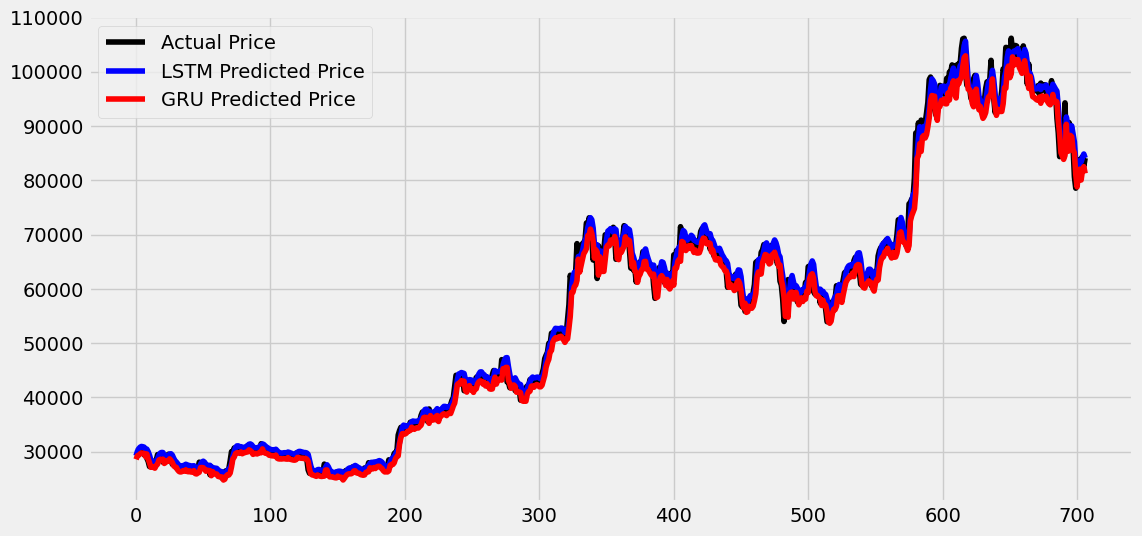

In [17]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual Price', color='black')
plt.plot(y_pred_lstm, label='LSTM Predicted Price', color='blue')
plt.plot(y_pred_gru, label='GRU Predicted Price', color='red')
plt.legend()
plt.show()

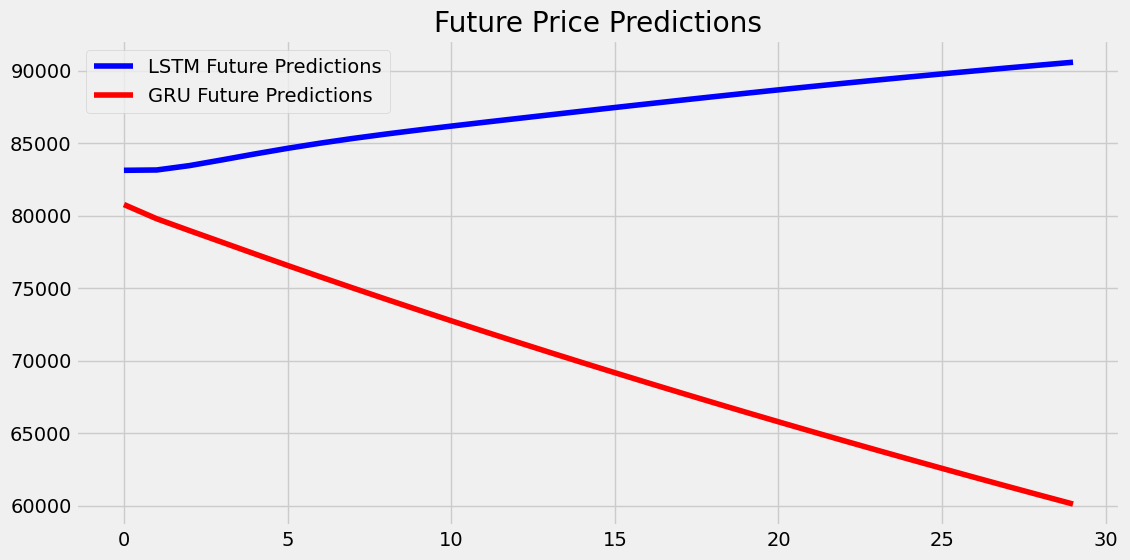

In [18]:
# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(range(len(y_future_lstm)), y_future_lstm, label='LSTM Future Predictions', color='blue')
plt.plot(range(len(y_future_gru)), y_future_gru, label='GRU Future Predictions', color='red')
plt.legend()
plt.title("Future Price Predictions")
plt.show()

In [19]:
# Get the last 60 days from dataset
last_60_days = data_scaled[-time_step:]
last_60_days = last_60_days.reshape(1, time_step, 1)

# Predict the next 10 days
future_predictions = []

for _ in range(10):
    predicted_price = gru_model.predict(last_60_days)  # Use GRU model for prediction
    future_predictions.append(predicted_price[0, 0])  # Store the prediction

    # Reshape predicted value to match input shape (1,1,1) and append
    predicted_price = np.reshape(predicted_price, (1, 1, 1))
    last_60_days = np.append(last_60_days[:, 1:, :], predicted_price, axis=1)

# Inverse transform predictions to actual prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create DataFrame for visualization
future_dates = pd.date_range(start=data.index[-1], periods=11, freq='D')[1:]
predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_predictions.flatten()})

print(predictions_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
        Date  Predicted Price
0 2025-03-19     80761.382812
1 2025-03-20     79782.179688
2 2025-03-21     78965.960938
3 2025-03-22     78162.515625
4 2025-03-23     77356.414062
5 2025-03-24     76559.976562
6 2025-03-25     75775.906250
7 2025-03-26     75003.210938
8 2025-03-27     74241.023438
9 2025-03-28     73488.835938


In [20]:
gru_model.save("crypto_model.keras")